<hr style="border:2px solid gray"> </hr>

# Homework 1 - Traveling Salesman Problem

## Example Code

### Algorithm 3: Simulated Annealing

### Author: Wangduk Seo (CAU AI Lab)
<hr style="border:2px solid gray"> </hr>

# Step 0. Importing packages and Global Settings

---------------------------------------------------------------
## (Optional) For Colab

In [ ]:
# from google.colab import drive
# import os, sys
# drive.mount('gdrive', force_remount=True)

---------------------------------------------------------------

In [149]:
# package list
import numpy as np
import sys
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import time

# Global Variables
# SA
MAX_EVALUATION = 1000
SUB_ITERATIONS = 100
TEMPERATURE = 100
COOLING_RATIO_1 = 0.5
COOLING_RATIO_2 = 0.9
COOLING_RATIO_THRESHOLD = 50
HEATING_RATIO = 1.1
TEMP_LIMIT = 1

# Plot Settings
PLOT_MODE = True # Draw Route
plt.ion()

# First City Index
FIRST_IDX = 0

In [145]:
file_path = 'data3.txt'

# Step 1. Data Loading

In [4]:
def fileloader():
    #     Data Format
    #     ---------------------------------------------------------
    #     NAME : pia3056
    #     COMMENT : Bonn VLSI data set with 3056 points
    #     COMMENT : Uni Bonn, Research Institute for Discrete Math
    #     COMMENT : Contributed by Andre Rohe
    #     TYPE : TSP
    #     DIMENSION : 3056 -----------------------------|
    #     EDGE_WEIGHT_TYPE : EUC_2D                     |
    #     NODE_COORD_SECTION                            |
    #     1 0 11 (2 dimentional coordinate of city)     |
    #     2 0 115                                       |
    #     ...                                           |
    #     ...(Total 3056 nodes)<------------------------|
    #     EOF
    #     ---------------------------------------------------------
    with open(file_path, "r") as file:
        file_str = file.readlines()

    # Get the coordinates of cities
    coord_str = file_str[8:-1]  # first city string to last city string (EOF 전까지)
    coord_list = np.zeros((len(coord_str), 2))
    for idx, item in enumerate(coord_str):
        items = item.split()
        coord_list[idx, 0], coord_list[idx, 1] = int(items[1]), int(items[2])

    return coord_list

# Step 2. Initialization

In [5]:
def initialize_greedy(coord_list, first_idx):
    cnt_cities = len(coord_list)
    # Initialize path and insert first city index to the first and last elements
    path = np.zeros(cnt_cities + 1, dtype=np.int32)
    # redefine first city index to random select
    first_idx = np.random.randint(cnt_cities, size=1)[0]
    path[0], path[-1] = first_idx, first_idx

    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    cities_tovisit = np.ones((cnt_cities), dtype=np.bool_)
    cities_tovisit[first_idx] = False

    # Iteratively Connect nearest cities
    for i in range(1, cnt_cities):
        start_idx = path[i - 1]
        distance_from_start = path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            # check the nearest city is visited
            if cities_tovisit[nearest_list[idx]]:
                nearest_city = nearest_list[idx]
                break
        cities_tovisit[nearest_city] = False
        path[i] = nearest_city

    return path_map, path


def initialize_random(coord_list, first_idx):
    cnt_cities = len(coord_list)
    path = np.zeros(cnt_cities + 1, dtype=np.int)

    path[0], path[-1] = first_idx, first_idx
    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    # city indices without first city index
    cities_tovisit = np.delete(np.arange(cnt_cities), first_idx)
    cities_random = np.random.permutation(cities_tovisit)
    path[1:-1] = cities_random

    return path_map, path

def path_cost(path_map, path):
    # The array of cost between cities in the path
    cnt_cities = path_map.shape[0]
    cost_arr = np.zeros(cnt_cities)
    for i in range(cnt_cities):
        cost_arr[i] = path_map[path[i], path[i+1]]

    return cost_arr

# Step 3. Searching a path

## Algorithm 2. Hill Climbing (2-opt search)

In [151]:
def two_opt_swap(path_map, path, iterations, coord_list, sa_start_time):
    cnt_cities = path_map.shape[0]
    # Save the best path

    cost_arr = path_cost(path_map, path)
    best_path = path.copy()
    best_cost = cost_arr.sum()
    
    # argsort cost array
    cost_idx_sort = np.argsort(cost_arr)
    
    # initialize temperature
    temperature = TEMPERATURE
    
    # for 10% of the longest distance cities in the path
    for c in range(cnt_cities//10):
        
        # check timeout
        if time.time()-sa_start_time>58:
#             print('timeout')
            break
            
        # save best cost
        temp_cost = best_cost.copy()
        
        # check all cities with 2-opt transformation
        for i in range(cnt_cities):
            
            # check timeout
            if time.time()-sa_start_time>58:
#                 print('timeout')
                break
            
            curr_path = best_path.copy()
            # Select two indices of flip points, one with the c'th longest distance in path
            sel_idx = np.sort(np.array([cost_idx_sort[-1-c], i]))
            sel_idx[0]+=1
            if sel_idx[0]==sel_idx[1]:
                continue

            # Path Flip and update cost array
            curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
            curr_cost_arr = path_cost(path_map, curr_path)

            # Compare to the best path
            curr_cost = curr_cost_arr.sum()
            if curr_cost < best_cost:
                best_path = curr_path
                best_cost = curr_cost
        
        # if cost has reduced, break loop
        if best_cost < temp_cost:
            break
        # if the c'th longest distance in the path didn't reduced, heat temperature and continue loop
        else:
            temperature = temperature * HEATING_RATIO
    
#     print(temperature)
    while temperature > TEMP_LIMIT:

        # check timeout
        if time.time()-sa_start_time>58:
            break
            
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)
        curr_cost = cost_arr.sum()

        if curr_cost <= best_cost:
            best_path, best_cost = curr_path, curr_cost
        else:
            prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))
            if prob > np.random.rand(1):
                best_path, best_cost = curr_path, curr_cost
        
        # if temperature lower than the threshold, apply another cooling ratio
        if temperature < COOLING_RATIO_THRESHOLD:
            temperature = temperature * COOLING_RATIO_2
        else:
            temperature = temperature * COOLING_RATIO_1
    return best_path, best_cost

In [153]:
def sa(path_map, path, coord_list):
    sa_start_time = time.time()
    best_path, best_cost = path.copy() , path_cost(path_map, path).sum()
    global TEMPERATURE
    
    # set max evaluation number to number of cities
    MAX_EVALUATION = path_map.shape[0]

    for i in range(MAX_EVALUATION):
        
        # check timeout
        if time.time()-sa_start_time>58:
            break
            
        curr_path = best_path.copy()
        new_path, new_cost = two_opt_swap(path_map, curr_path, SUB_ITERATIONS, coord_list, sa_start_time)

        if new_cost < best_cost:
#             print(best_cost, '===>', new_cost)
            best_path, best_cost = new_path, new_cost

    if PLOT_MODE:
        plt.close()
        figure, ax = plt.subplots()
        plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
        plt.title('City Route')
        coord_path = coord_list
        coord_path = np.append(coord_path, coord_path[best_path[0], :].reshape(1, 2), axis=0)
        coord_path[:, :] = coord_path[best_path, :]
        lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
        figure.canvas.draw()
        figure.canvas.flush_events()
        plt.show()

    return best_path, best_cost

# Main

/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_30187/297467567.py:77: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


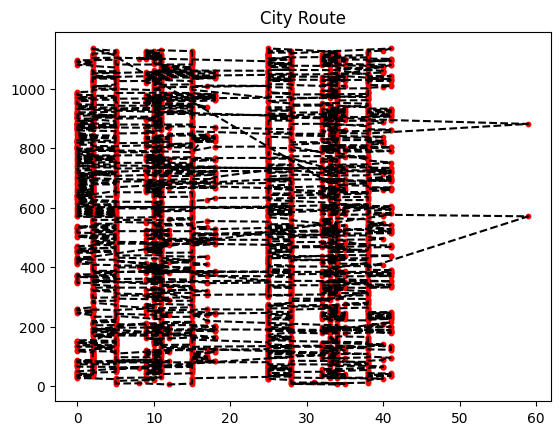

Execution Time: 58.71691608428955
Path: [2845, 3111, 3112, 2846, 2847, 3113, 3114, 2848, 2646, 3243, 3425, 3424, 3423, 3422, 3242, 3110, 3420, 3419, 3614, 3613, 3418, 3417, 3612, 3611, 3520, 3416, 3415, 3103, 2839, 2840, 3104, 3105, 3240, 2841, 2643, 2842, 3106, 3107, 2843, 2644, 3241, 3109, 2645, 2466, 2142, 2143, 2144, 2145, 2467, 2469, 2470, 2471, 2472, 2149, 2148, 2147, 2146, 1852, 1851, 1699, 1700, 1506, 1396, 1127, 927, 1126, 1395, 1394, 1505, 1125, 926, 1393, 925, 1392, 1697, 1850, 1849, 1504, 1391, 1124, 923, 922, 1123, 1390, 1389, 1122, 921, 920, 1121, 1387, 1386, 1120, 919, 1119, 1385, 1384, 1118, 1117, 1383, 1382, 1116, 1115, 1381, 1380, 1114, 1113, 1379, 1689, 1691, 1692, 1693, 1694, 1695, 1696, 756, 755, 754, 753, 752, 751, 749, 415, 416, 82, 83, 417, 418, 84, 419, 420, 422, 86, 423, 424, 425, 426, 427, 87, 428, 429, 430, 431, 88, 433, 434, 435, 436, 90, 437, 762, 763, 764, 439, 440, 91, 442, 443, 444, 93, 766, 765, 928, 1128, 1397, 1701, 1854, 1853, 1855, 1856, 1703, 1507

In [155]:
# Initialization ###############
initialize = initialize_greedy
#initialize = initialize_random
################################

# Step 1
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()
# Step 2
path_map, path = initialize(coord_list, FIRST_IDX)

# Step 3
best_path, best_cost = sa(path_map, path, coord_list)

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))